In [5]:
import sys
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("/home/share/libraries/bdpy")
import bdpy
from bdpy.preproc import select_top
from bdpy.ml import add_bias, make_cvindex
from bdpy.stats import corrcoef

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC

from util import make_dataset
from util import cross_validation

In [2]:
v_spec = np.load("record/ventricle_spectrum.npy")
a_spec = np.load("record/article_spectrum.npy")
# list for sampling features
NUM_FEATURES = [i for i in range(1, 100)] + [i * 50 for i in range(2, 45)]

In [50]:
# ventricle: 0, article: 1
# choose 71 samples from vertricle and make test data and label data
def make_dataset(v_spec, a_spec, shuffle=False):
    """
    choose 71 samples from vertricle and make data and label data
    """
    N = a_spec.shape[0]
    choice = np.random.choice(v_spec.shape[0], size=N)
    v_spec_random = v_spec[choice]
    choice = np.random.choice(N, size=N)
    a_spec_random = a_spec[choice]
    data = np.vstack((v_spec_random, a_spec_random))
    # create dataset and labels(v: 0, a:1)
    label = np.array([0] * N + [1] * N)
    # shuffle data and label if shuffle == True
    if shuffle:
        random_index = [i for i in range(data.shape[0])]
        random.shuffle(random_index)
        data = data[random_index]
        label = label[random_index]
    return data, label

In [51]:
def cross_validation(data, label, n=10):
    """
    return list of train_data, test_data, train_label, test_label
    
    return
        list: list of shape(n, 4)
    """
    index = np.arange(data.shape[0])
    index = index % n
    cvindex = make_cvindex(index)
    cvindex = np.array(cvindex)
    cross_valid = []
    for i in range(cvindex.shape[2]):
        train_data = data[cvindex[0][:, i] == True]
        test_data = data[cvindex[1][:, i] == True]
        train_label = label[cvindex[0][:, i] == True]
        test_label = label[cvindex[1][:, i] == True]
        cross_valid.append((train_data, test_data, train_label, test_label))
    return cross_valid

In [3]:
# use linar SVM and calculate the score
def classify(train_data, test_data, train_label, test_label, n_features):
    # scale data
    scaler = StandardScaler()
    scaler.fit(train_data)
    scaled_train_data = scaler.transform(train_data)
    scaled_test_data = scaler.transform(test_data)
    # train classifier
    clf = LinearSVC()
    # use n_features
    clf.fit(scaled_train_data[:, : n_features], train_label)
    # get score
    score = clf.score(scaled_test_data[:, :n_features], test_label)

    return score

In [6]:
%matplotlib
#put data to score_record and get sum 
score_record = []
line, = plt.plot(0,0)
plt.xlim(0,2250)
plt.ylim(0.45, 0.90)
trial = 0
for count, num_features in enumerate(NUM_FEATURES):
    if num_features % 100 == 0:
        print("number of features:{0}".format(num_features))
    accuracy = []
    for i in range(10):
        data, label = make_dataset(v_spec, a_spec)
        cross_valid = cross_validation(data, label, n=10)

        # for each train-test in cross validation
        for  train_data, test_data, train_label, test_label in cross_valid:
            score = classify(train_data, test_data, train_label, test_label, num_features)
            accuracy.append(score)
    score_record.append(accuracy)
    mean = np.array(score_record)[:count].mean(axis=1)
    line.set_data(NUM_FEATURES[:count], mean)
    plt.pause(0.001)
    

Using matplotlib backend: Qt4Agg
number of features:100
number of features:200
number of features:300
number of features:400
number of features:500
number of features:600
number of features:700
number of features:800
number of features:900
number of features:1000
number of features:1100
number of features:1200
number of features:1300
number of features:1400
number of features:1500
number of features:1600
number of features:1700
number of features:1800
number of features:1900
number of features:2000
number of features:2100
number of features:2200


/home/python/2.7/lib/python2.7/site-packages/matplotlib/backend_bases.py:2435: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


In [7]:
score_record = np.array(score_record)
mean = score_record.mean(axis=1)
std = score_record.std(axis=1)

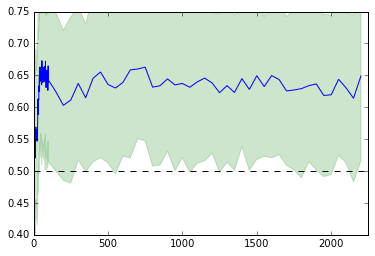

In [8]:
%matplotlib inline
# plot figure
plt.plot(NUM_FEATURES, mean)
plt.fill_between(NUM_FEATURES, mean - std, mean + std, alpha = 0.2, color = "green")
plt.xlim(0, 2250)
plt.ylim((0.4, 0.75))
plt.axhline(0.5, linestyle="--", color="black")